In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
#!pip install mne

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import math
import mne
%matplotlib inline

In [4]:
epochs = mne.read_epochs('Data/epocas/oddball_epo.fif')

Reading /home/ivandanielvillegas/work/home/BrainInvaders/Data/epocas/oddball_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
60154 matching events found
No baseline correction applied
0 projection items activated


## Sub Sampling

In [5]:
# Reducir la frecuencia de muestreo a 100 Hz
epochs_resampled = epochs.copy().resample(125)

In [6]:
n_data1 = epochs[0].get_data()
n_data1[0][0].size

513

In [7]:
epochs_resampled[0].get_data().size
n_data2 = epochs_resampled[0].get_data()
n_data2[0][0].size

125

In [8]:
epochs_resampled.save('Data/epocas/oddball_subsampl_epo.fif',overwrite=True)

Overwriting existing file.


In [2]:
epochs_resampled = mne.read_epochs('Data/epocas/oddball_subsampl_epo.fif')

Reading /home/ivandanielvillegas/work/home/BrainInvaders/Data/epocas/oddball_subsampl_epo.fif ...
    Found the data of interest:
        t =    -304.00 ...     688.00 ms
        0 CTF compensation matrices available
Not setting metadata
60154 matching events found
No baseline correction applied
0 projection items activated


## Se balancea el set de datos

In [ ]:
event_dict = {"NoP300":0,"P300":1}
epochs_equalized = epochs_resampled.copy()
epochs_equalized.equalize_event_counts(event_dict)

In [ ]:
epochs_equalized['P300']

In [ ]:
epochs_equalized['NoP300']

In [3]:
epochs_equalized = epochs_resampled.copy()

## Se agrupan los electrodos segun la zona de la corteza cerebral

In [4]:
info = epochs_equalized.info
ch_names = info['ch_names']
electrodos_F = [ch_name for ch_name in ch_names if 'F' in ch_name]
electrodos_C = [ch_name for ch_name in ch_names if ch_name.startswith('C')] #.startswith('C')
electrodos_O = [ch_name for ch_name in ch_names if 'O' in ch_name]
electrodos_P = [ch_name for ch_name in ch_names if ch_name.startswith('P')]
#electrodos_C, electrodos_O, electrodos_P

In [5]:
S_O = epochs_equalized.copy().pick_channels(electrodos_O)
S_C = epochs_equalized.copy().pick_channels(electrodos_C)
S_P = epochs_equalized.copy().pick_channels(electrodos_P)
S_F = epochs_equalized.copy().pick_channels(electrodos_F)
#S_O.info

In [6]:
data_OT = S_O["P300"].get_data()
data_CT = S_C["P300"].get_data()
data_PT = S_P["P300"].get_data()
data_FT = S_F["P300"].get_data()
print(data_OT.shape)
# Sumar los valores de los electrodos
mean_data_OT = data_OT.mean(axis=1)
mean_data_CT = data_CT.mean(axis=1)
mean_data_PT = data_PT.mean(axis=1)
mean_data_FT = data_FT.mean(axis=1)
mean_data_OT.shape, mean_data_CT.shape, mean_data_PT.shape, mean_data_FT.shape

(10026, 3, 125)


((10026, 125), (10026, 125), (10026, 125), (10026, 125))

In [7]:
data_OF = S_O["NoP300"].get_data()
data_CF = S_C["NoP300"].get_data()
data_PF = S_P["NoP300"].get_data()
data_FF = S_F["NoP300"].get_data()
print(data_OT.shape)
# Sumar los valores de los electrodos
mean_data_OF = data_OF.mean(axis=1)
mean_data_CF = data_CF.mean(axis=1)
mean_data_PF = data_PF.mean(axis=1)
mean_data_FF = data_FF.mean(axis=1)
mean_data_OF.shape, mean_data_CF.shape, mean_data_PF.shape, mean_data_FF.shape

(10026, 3, 125)


((50128, 125), (50128, 125), (50128, 125), (50128, 125))

In [8]:
# Concatenar los tres np.array a lo largo del segundo eje
data_T = np.concatenate((mean_data_OT[:, np.newaxis, :], mean_data_CT[:, np.newaxis, :], mean_data_PT[:, np.newaxis, :], mean_data_FT[:, np.newaxis, :]), axis=1)
data_F = np.concatenate((mean_data_OF[:, np.newaxis, :], mean_data_CF[:, np.newaxis, :], mean_data_PF[:, np.newaxis, :], mean_data_FF[:, np.newaxis, :]), axis=1)
data_T.shape, data_F.shape

((10026, 4, 125), (50128, 4, 125))

## Se vuelve a convertir a epocas

In [9]:
ch_names = ['O','C','P','F']
events = S_O['P300'].events
print(events[1])
ch_types = ['eeg','eeg','eeg','eeg']
sfreq = 125
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
epochs_T = mne.EpochsArray(data=data_T, info=info, events=events)

[4623    0    1]
Not setting metadata
10026 matching events found
No baseline correction applied
0 projection items activated


In [10]:
ch_names = ['O','C','P','F']
events = S_O['NoP300'].events
print(events[1])
ch_types = ['eeg','eeg','eeg','eeg']
sfreq = 125
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
epochs_F = mne.EpochsArray(data=data_F, info=info, events=events)

[2907    0    0]
Not setting metadata
50128 matching events found
No baseline correction applied
0 projection items activated


In [11]:
epochs_list = [epochs_T, epochs_F]
epochs_concatenated = mne.concatenate_epochs(epochs_list)

Not setting metadata
60154 matching events found
No baseline correction applied


In [12]:
epochs_shifted = epochs_concatenated.shift_time(-0.3)

In [13]:
epochs_shifted.save('Data/epocas/elect_mean_epo.fif',overwrite=True)

Overwriting existing file.


Not setting metadata
10026 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-14-7384e7c2e8aa>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['1'].plot_image(picks=['F'])#P300


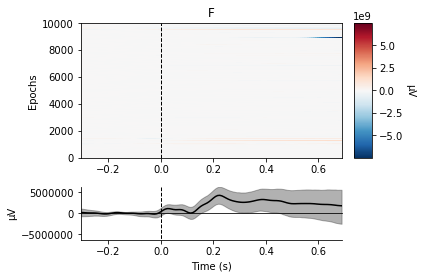

Not setting metadata
50128 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-14-7384e7c2e8aa>:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['0'].plot_image(picks=['F'])#NoP300


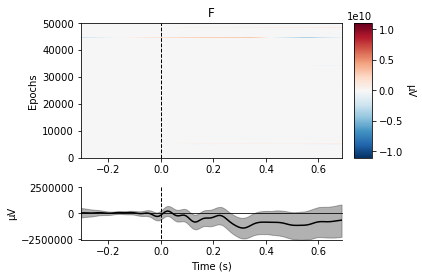

[<Figure size 432x288 with 3 Axes>]

In [14]:
epochs_shifted['1'].plot_image(picks=['F'])#P300
epochs_shifted['0'].plot_image(picks=['F'])#NoP300

Not setting metadata
10026 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-15-ac3baa63d0b2>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['1'].plot_image(picks=['C'])#P300


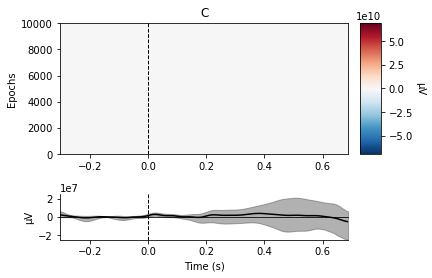

Not setting metadata
50128 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-15-ac3baa63d0b2>:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['0'].plot_image(picks=['C'])#NoP300


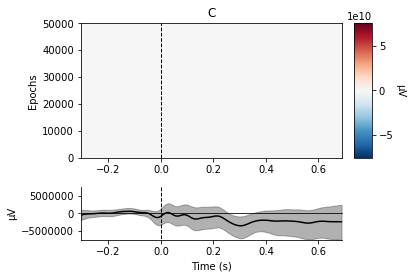

[<Figure size 432x288 with 3 Axes>]

In [15]:
epochs_shifted['1'].plot_image(picks=['C'])#P300
epochs_shifted['0'].plot_image(picks=['C'])#NoP300

Not setting metadata
10026 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-16-a4ddccaaaad9>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['1'].plot_image(picks=['P'])#P300


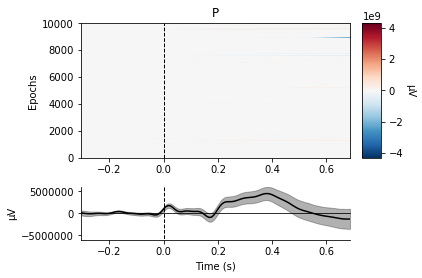

Not setting metadata
50128 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-16-a4ddccaaaad9>:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_shifted['0'].plot_image(picks=['P'])#NoP300


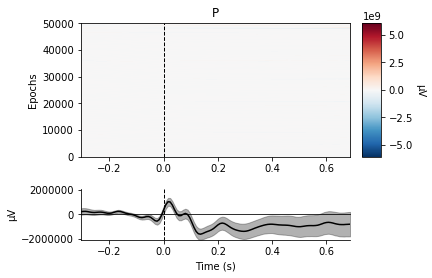

[<Figure size 432x288 with 3 Axes>]

In [16]:
epochs_shifted['1'].plot_image(picks=['P'])#P300
epochs_shifted['0'].plot_image(picks=['P'])#NoP300